(techniques:transparent_function_execution)=
# Transparent Symbolic Execution of Function Calls 

In [1]:
import utils
from minipy import *
from semantics import *
from symbolic_interpreter import *

Sometimes, one is not only concerned about the final outcome of a symbolic execution, but additionally intends to explore intermediate states leading to these results. An example application where this is the case is *symbolic debugging* (see {ref}`applications:symbolic_debugging`): If an execution result is not as expected, inspecting intermediate states can help locating and ultimately fixing the issue. Our symbolic interpreter defined in {ref}`foundations:symbolic_interpreter` has a flaw in this regard. Consider again the execution of our linear search program:

In [2]:
search_program="""
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
            
        i = i + 1
    else:
        return -1
    
    return i

t = (1, 2, 3, 4, )
r = find(x, t)
"""

display_program(search_program)

```python
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
            
        i = i + 1
    else:
        return -1
    
    return i

t = (1, 2, 3, 4, )
r = find(x, t)
```

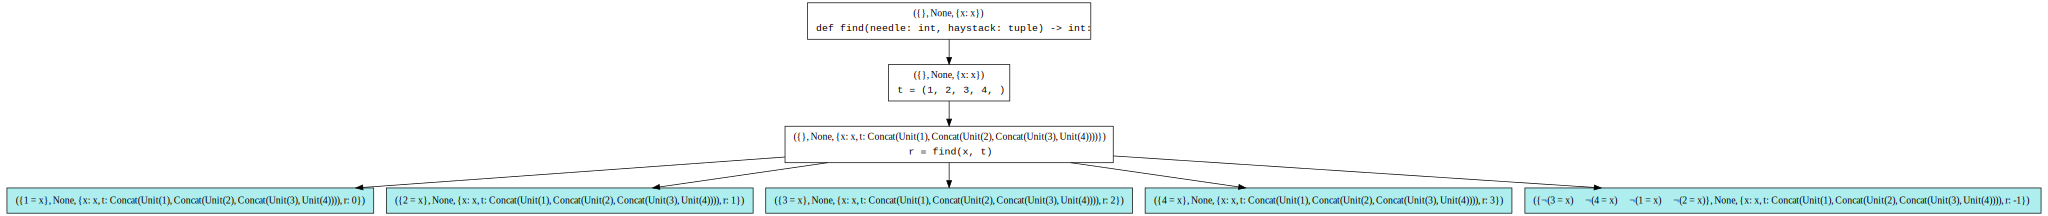

In [3]:
x = Variable("x", INT_TYPE)
env = SymbolicEnvironment(SymbolicStore({x: x.to_z3()}))
predicates = {"len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)}
interpreter = SymbolicInterpreter(predicates=predicates)

search_program_ast = parse(search_program)
tree = interpreter.execute(search_program_ast, env)
display_set(tree)

Inspecting the execution tree for the function is not much more useful than examining the leaves only, since the tree proceeds from the assignment with the function call to the results of the call *in a single step*. If there was a bug within the `find` method, this SET does not help locating it.

An alternative to our previous design choice of processing a function definition by storing a continuation returning an evaluation result is to *replace* a function call by the function's body. We call this process *inlining*. This approach ensures transparency in the sense that the function body appears in the final SET, but requires some program transformation inside the body. In the case of the minipy language, it suffices to transform `return` statements to assignments. For example, we replace the statement `r = find(x, t)` above with the body of `find`, such that (1) function parameters in the body are instantiated correctly and (2) all `return expr` statements are replaced by `r = expr`. For an object-oriented language, we additionally have to instantiate `self` calls to the containing object and possibly handle visibility rules according to the context of the call. Note that even such relatively simple code transformations are error-prone: In the case of `return` transformations, it is most problematic that `return`s lead to abrupt completion of the surrounding method's execution. Thus, we cannot simply replace a `return` statement with an assignment. Furthermore, one has to correctly handle nested function definitions, and replace `return` statements with an assignment to the "right" variable. 

To avoid these kinds of deep program transformations, we can *embed* the original function bodies into an artificial *wrapper statement providing the required context*, extending the symbolic interpreter to support such statements. *Method frames* {cite}`ahrendt.beckert.ea-16` as implemented in the KeY [^key] symbolic execution engine for the Java language realize this idea. In the context of minipy, a method frame statement has the following shape:

```python
method-frame(result=var):
    body
```

where `body` is the function body and `var` is a variable name identifying the assignment target of returned expressions inside `body`.

## Parsing Method Frames and Transforming Function Calls

We extend the minipy language to support method frames, that is, we add method frames to the grammar, add a new AST node class, and extend the `ASTConverter`. Finally, we re-declare the `parse` function to use the new `ASTConverter` class.

In [4]:
#% EXPORT
MINIPY_GRAMMAR["<compound_stmt>"].insert(0, "<method_frame>")
MINIPY_GRAMMAR["<method_frame>"] = ["method-frame(result=<NAME>):<block>"]

In [5]:
class MethodFrame(ASTNode):
    def __init__(self, result: 'NameAtom', block: Block):
        super().__init__(f"method-frame(result={result.name}):\n{indent(block.code, '    ')}")
        self.result = result
        self.block = block

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(MethodFrame(self.result.transform(transformer), self.block.transform(transformer)))

In [6]:
class ASTConverter(ASTConverter):
    def __init__(self):
        super().__init__()
        self.stmt_interpretations["<method_frame>"] = self.transform_method_frame_stmt
        
    def transform_method_frame_stmt(self, stmt: ParseTree) -> MethodFrame:
        m_res = match(("method-frame(result=", "<NAME>", "):", "<block>"), stmt)
        assert m_res is not None

        return MethodFrame(self.transform_atom(m_res[1]), self.transform_block(m_res[-1]))

In [7]:
def parse(inp: str) -> 'ASTNode':
    inp = strip_comments_and_whitespace(inp)
    tree = PythonPEGParser(MINIPY_GRAMMAR).parse(inp)[0]
    return ASTConverter().transform_top(tree)

Now we should be able to parse a program containing a method frame statement:

In [8]:
mf_stmt = """
x = 17

method-frame(result=x):
    i = 42 + x
    return i
"""

display_program(mf_stmt)

```python
x = 17

method-frame(result=x):
    i = 42 + x
    return i
```

In [9]:
display_program(parse(mf_stmt).code)

```python
x = 17
method-frame(result=x):
    i = (42 + x)
    return i
```

The next step is to transform function calls in ASTs to method frames. We do so by writing three visitors/transformers, using the transformer infrastructure (method `transform`) of the `ASTNode` classes. Specifically, we implement

1. A transformer (which is actually a "pure" visitor) `UsedVariablesVisitor` which collects variables used in a program,
2. a transformer `ReplaceFunctionCallsTransformer` collecting function calls in expressions, replacing them with fresh variables, and
3. the actual `MethodFrameTransformer` for replacing calls by method frames.

The `UsedVariablesVisitor` is easy to implement:

In [10]:
class UsedVariablesVisitor:
    def __init__(self):
        self.result: Set[str] = set()

    def __call__(self, *args, **kwargs):
        assert len(args) == 1
        assert not kwargs
        assert isinstance(args[0], ASTNode)
        node: ASTNode = args[0]

        if isinstance(node, NameAtom):
            self.result.add(node.name)
        elif isinstance(node, Assignment):
            self.result.add(node.lhs)

        return node

    @staticmethod
    def get_used_variables(node: ASTNode) -> Set[str]:
        visitor = UsedVariablesVisitor()
        node.transform(visitor)
        return visitor.result

In [11]:
search_program_ast = parse(search_program)
UsedVariablesVisitor.get_used_variables(search_program_ast)

{'haystack', 'i', 'needle', 'r', 't', 'x'}

The class `ReplaceFunctionCallsTransformer` replaces each function call by a fresh variable and stores the mapping between introduced variables and replaced function calls to be retrieved for callers of the transformer. It requires a list of declared function names to make sure that no built-in functions or predicates are replaced.

In [12]:
class ReplaceFunctionCallsTransformer:
    def __init__(self, used_variables: Set[str], declared_functions: Set[str]):
        self.used_variables = copy.copy(used_variables)
        self.fresh_var_counter = 0
        self.replacements: Dict[str, FunctionCall] = {}
        self.declared_functions = declared_functions

    def fresh_variable(self) -> str:
        candidate = f"var_{self.fresh_var_counter}"
        while candidate in self.used_variables:
            self.fresh_var_counter += 1
            candidate = f"var_{self.fresh_var_counter}"
        self.used_variables.add(candidate)
        return candidate

    def __call__(self, *args, **kwargs):
        assert len(args) == 1
        assert not kwargs
        assert isinstance(args[0], ASTNode)
        node: ASTNode = args[0]

        if isinstance(node, FunctionCall) and node.name in self.declared_functions:
            fresh_var = self.fresh_variable()
            self.replacements[fresh_var] = node
            return NameAtom(fresh_var)

        return node

We declare a class `FilterASTVisitor`, which can be used, for example, to retrieve declared functions.

In [13]:
class FilterASTVisitor:
    def __init__(self, filter: Callable[[ASTNode], bool]):
        self.result: OrderedSet[ASTNode] = OrderedSet([])
        self.filter = filter

    def __call__(self, *args, **kwargs):
        assert len(args) == 1
        assert not kwargs
        assert isinstance(args[0], ASTNode)
        node: ASTNode = args[0]

        if self.filter(node):
            self.result.add(node)

        return node    
    
    @staticmethod
    def filter(node: ASTNode, filter: Callable[[ASTNode], bool]) -> OrderedSet[ASTNode]:
        visitor = FilterASTVisitor(filter)
        node.transform(visitor)
        return visitor.result

In [14]:
program_with_many_calls = """
def f(a: int) -> int:
    return a + 1

def g(b: int) -> bool:
    return b > 0

if f(x) + f(y) * 2 and Predicate(f(x)):
    assert g(13) and True 
    return 17 + f(y + x)
else:
    assert g(z) and f(z) > 3
"""

display_program(program_with_many_calls)

```python
def f(a: int) -> int:
    return a + 1

def g(b: int) -> bool:
    return b > 0

if f(x) + f(y) * 2 and Predicate(f(x)):
    assert g(13) and True 
    return 17 + f(y + x)
else:
    assert g(z) and f(z) > 3
```

In [15]:
program_with_many_calls_ast = parse(program_with_many_calls)
transformer = ReplaceFunctionCallsTransformer(
    UsedVariablesVisitor.get_used_variables(program_with_many_calls_ast),
    {function.name for function in FilterASTVisitor.filter(
        program_with_many_calls_ast, lambda n: isinstance(n, FunctionDef))}
)
result = program_with_many_calls_ast.transform(transformer)

display_program(result.code)

```python
def f(a: int) -> int:
    return (a + 1)
def g(b: int) -> bool:
    return (b > 0)
if ((var_0 + (var_1 * 2)) and Predicate(var_2)):
    assert (var_3 and True)
    return (17 + var_4)
else:
    assert (var_5 and (var_6 > 3))
```

In [16]:
{variable: call.code for variable, call in transformer.replacements.items()}

{'var_0': 'f(x)',
 'var_1': 'f(y)',
 'var_2': 'f(x)',
 'var_3': 'g(13)',
 'var_4': 'f((y + x))',
 'var_5': 'g(z)',
 'var_6': 'f(z)'}

The `MethodFrameTransformer` stores information about all function *definitions* in the program being transformed, since the function bodies are needed for creating the method frames. Concretely, we maintain a mapping `self.functions: Dict[str, Callable[[List[Expression]], Block]]` from function names to functions taking a list of argument expressions to instantiate the formal parameters of the parsed function and returning its body. At the beginning of the returned body, we add a sequence of assignments setting the values of the formal parameters.

All statements whose AST classes immediately contain expressions are transformed to a sequence of method frames for all function calls occurring in the transformed statement, followed by the statement itself (with calls replaced by fresh variables used in method frames).

In [17]:
class MethodFrameTransformer:
    def __init__(self, node: ASTNode):
        self.used_variables = UsedVariablesVisitor.get_used_variables(node)
        self.functions: Dict[str, Callable[[List[Expression]], Block]] = {}

    def __call__(self, *args, **kwargs):
        assert len(args) == 1
        assert not kwargs
        assert isinstance(args[0], ASTNode)
        node: ASTNode = args[0]

        if isinstance(node, FunctionDef):
            return self.process_function_def(node)
        elif isinstance(node, Assignment):
            expression, method_frames = self.process_expression(node.expression)
            return Stmts(method_frames + [Assignment(node.lhs, expression)])
        elif isinstance(node, Assert):
            expression, method_frames = self.process_expression(node.expression)
            return Stmts(method_frames + [Assert(expression)])
        elif isinstance(node, ReturnStmt):
            expression, method_frames = self.process_expression(node.expression)
            return Stmts(method_frames + [ReturnStmt(expression)])
        elif isinstance(node, IfStmt):
            guard, method_frames = self.process_expression(node.guard)
            return Stmts(method_frames + [IfStmt(guard, node.then_block, node.else_block)])

        return node

    def process_expression(self, expression: Expression) -> Tuple[Expression, List[ASTNode]]:
        call_transformer = ReplaceFunctionCallsTransformer(
            self.used_variables,
            {function_name for function_name in self.functions.keys()}
        )
        expression = expression.transform(call_transformer)
        self.used_variables |= call_transformer.used_variables
        method_frames = [
            MethodFrame(NameAtom(variable), self.functions[f_call.name](f_call.args))
            for variable, f_call in call_transformer.replacements.items()
        ]
        return expression, method_frames

    def process_function_def(self, node: FunctionDef):
        def get_block(params: List[Expression]):
            assert len(params) == len(node.params)

            stmts = [
                Assignment(node.params[i].name, params[i])
                for i in range(len(params))
            ]
            stmts += node.block.stmts

            return Block(stmts)

        self.functions[node.name] = get_block
        return node

In [18]:
transformer = MethodFrameTransformer(program_with_many_calls_ast)
display_program(program_with_many_calls_ast.transform(transformer).code)

```python
def f(a: int) -> int:
    return (a + 1)
def g(b: int) -> bool:
    return (b > 0)
method-frame(result=var_4):
    a = x
    return (a + 1)
method-frame(result=var_5):
    a = y
    return (a + 1)
method-frame(result=var_6):
    a = x
    return (a + 1)
if ((var_4 + (var_5 * 2)) and Predicate(var_6)):
    method-frame(result=var_0):
        b = 13
        return (b > 0)
    assert (var_0 and True)
    method-frame(result=var_1):
        a = (y + x)
        return (a + 1)
    return (17 + var_1)
else:
    method-frame(result=var_2):
        b = z
        return (b > 0)
    method-frame(result=var_3):
        a = z
        return (a + 1)
    assert (var_2 and (var_3 > 3))
```

The astute reader might have noticed that we did not implement a transformation for calls in the guards of `while` statements. Since loop guards are evaluated repeatedly, replacing them requires the introduction of more than one method frame: One before the loop, one before every `continue` statement, and one after each code point in the loop body leading to a normal completion of the body. This kind of complex code transformation is exactly what we are trying to *avoid* by the introduction of method frames. In {ref}`techniques:loops_static_se`, we describe how to eliminate loops using loop invariants in the context of *static* symbolic execution. Ultimately, this results in the replacement of `while` by `if` statements, such that we can use the `MethodFrameTransformer` for the resulting programs without further modification.

## Semantics and Symbolic Execution of Method Frames

Intuitively, the semantics of a method frame statement equals the semantics of its body, with the exception that a `return expr` statement in the body leads to an assignment of `expr` to the `result` variable of the method frame. More precisely, in the style of the Java Language Specification {cite}`gosling.joy.ea-05`:

A method frame statement with result variable `result` and body `body` is executed by executing `body`. Then there is a choice:

1. If the execution of `body` completes abruptly because of a `return` of a value `value`, the method frame statement completes normally and `value` is assigned to `result`.
2. If the execution of `body` completes abruptly because of any other reason, the method frame statement completes abruptly for the same reason.

Note that we did not define the case where `body` completes normally. The reason for this is that in `minipy`, we only have side effect-free functions which should always return a value if there is no other reason for their abrupt completion.

We can formalize the semantics of method frames even further by implementing it in the concrete minipy interpreter.

In [19]:
class Interpreter(Interpreter):
    def __init__(self):
        super().__init__()
        self.stmt_interpretations[MethodFrame] = self.execute_method_frame
        
    def execute_method_frame(self, stmt: MethodFrame, environment: Environment) -> None:
        try:
            self.execute_block(stmt.block, environment)
            assert False
        except Exception as exc:
            if isinstance(exc, Return):
                variable = Variable(stmt.result.name, get_type(exc.value))
                environment[variable] = exc.value
            else:
                raise exc

We can used this mechanized semantics to check whether our `MethodFrameTransformer` preserves the meaning of the transformed programs. Let us compare the execution results for the linear search program and its transformed version:

In [20]:
transformer = MethodFrameTransformer(search_program_ast)
search_program_transformed = search_program_ast.transform(transformer)
display_program(search_program_transformed.code)

```python
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while (i < len(haystack)):
        if (haystack[i] == needle):
            break
        i = (i + 1)
    else:
        return -1
    return i
t = (1, 2, 3, 4, )
method-frame(result=var_0):
    needle = x
    haystack = t
    i = 0
    while (i < len(haystack)):
        if (haystack[i] == needle):
            break
        i = (i + 1)
    else:
        return -1
    return i
r = var_0
```

In [21]:
x = Variable("x", INT_TYPE)

In [22]:
interpreter = Interpreter()
environment = Environment()
environment[x] = 3
interpreter.execute(search_program_ast, environment)
environment["r"]

2

In [23]:
interpreter = Interpreter()
environment = Environment()
environment[x] = 3
interpreter.execute(search_program_transformed, environment)
environment["r"]

2

After this promising result, we continue with the (straightforward) extension of the *symbolic* interpreter.

In [24]:
class SymbolicInterpreter(SymbolicInterpreter):
    def __init__(self,
                 loop_unrolling_threshold: Optional[int] = None,
                 predicates: Optional[Dict[str, Tuple[Tuple[z3.SortRef, ...], z3.SortRef, Callable]]] = None):
        super().__init__(loop_unrolling_threshold, predicates)
        self.stmt_interpretations[MethodFrame] = self.execute_method_frame
        
    def execute_method_frame(self, stmt: MethodFrame, environment: SymbolicEnvironment) -> SET:
        tree = self.execute_block(stmt.block, environment)
        result = (SETNode(environment, stmt.code), [tree])

        for leaf in get_leaves(tree):
            node, _ = leaf
            exc = node.environment.abrupt_completion

            assert exc is not None

            if isinstance(exc, SymbolicReturn):
                variable = Variable(stmt.result.name, get_type_for_z3_expr(exc.value))
                result = replace_in_tree(
                    result, leaf, (SETNode(
                        node.environment.set(variable, exc.value).set_abrupt_completion(None)), []))

        return result

Now, symbolically executing the linear search program (with method frames) yields an SET which is *transparent* in the sense that all executed statements actually occur:

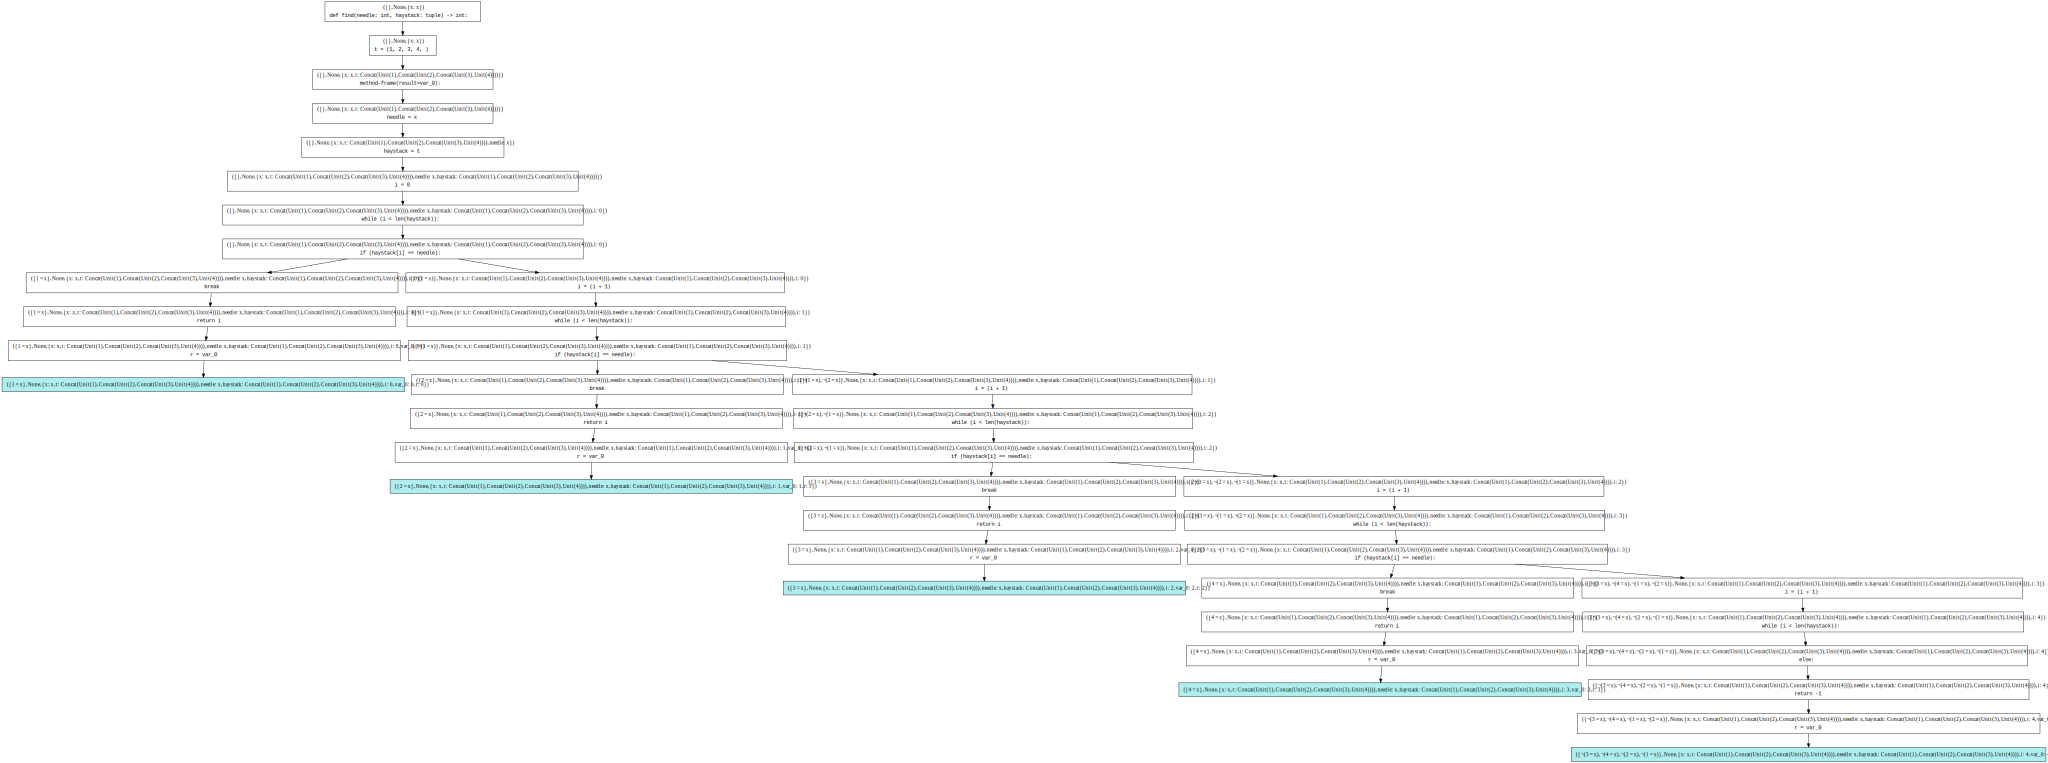

In [25]:
environment = SymbolicEnvironment().set(x, x.to_z3())
predicates = {"len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)}
interpreter = SymbolicInterpreter(predicates=predicates)
tree = interpreter.execute(search_program_transformed, environment)
display_set(tree)

In the next section, we discuss how to handle unbounded loops in static, exhaustive symbolic execution. In the course of this, we also introduce so-called *loop scopes*, another kind of artificial statement related to method frames with the purpose of enabling sound static symbolic execution of loops with minimal program transformation.

## References

```{bibliography}
:filter: docname in docnames
```

[^key]: https://www.key-project.org